In [1]:
#prophet
import pandas as pd
import numpy as np
from prophet import Prophet
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### <우리의 투자 수익 계산 방식에서 필요한 정보>

1. **매수 시점**과 그 시점의 **종가**
2. **매수 종가**를 기준으로 **최소 수익 시점** 예측
3. 최소 수익이 가능한 시점 내에서 **최대 수익이 가능한 매도 시기** 예측

# 초기 파라미터 설정
- visa 주식의 일일 종가 데이터 input -> **daily_seasonality 활성화**
- visa의 시장은 더욱 확대되고 주식에서도 점진적으로 진폭이 증가하고 있음 -> **곱연산 (multiplicative) 모드**
- 연간 트렌드와 특이점인 **올림픽/월드컵** 그리고 **코로나**와 같은 시기는 **holiday** 파라미터 세팅

최근 5년 (2019년부터 최근까지의) 데이터로 학습 진행

In [2]:
start = '2019-01-01'
end = '2024-03-06'
ticker='V'  # visa ticker

df = yf.download(ticker, start=start, end=end)
df['ds'] = pd.to_datetime(df.index, format='%Y-%m-%d')
df['y'] = df['Close']
df = df[['ds', 'y']]

[*********************100%%**********************]  1 of 1 completed


In [3]:
# holiday 파라미터로 입력해주는 기간 (특이점/이상치): 코로나, 올림픽/월드컵
# 참고: https://facebook.github.io/prophet/docs/handling_shocks.html#changes-in-seasonality-between-pre--and-post-covid
event = pd.DataFrame([
    {'holiday': 'covid-19', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'olympic_summer', 'ds': '2021-07-23', 'lower_window': 0, 'ds_upper': '2021-08-08'},
    {'holiday': 'olympic_winter', 'ds': '2022-02-04', 'lower_window': 0, 'ds_upper': '2022-02-20'},
    {'holiday': 'worldcup', 'ds': '2022-11-20', 'lower_window':0, 'ds_upper': '2022-12-18'}
])
for t_col in ['ds', 'ds_upper']:
    event[t_col] = pd.to_datetime(event[t_col])
event['upper_window'] = (event['ds_upper'] - event['ds']).dt.days   # 기간 일수 계산
event

,holiday,ds,lower_window,ds_upper,upper_window
0,covid-19,2020-03-21,0,2021-06-10,446
1,olympic_summer,2021-07-23,0,2021-08-08,16
2,olympic_winter,2022-02-04,0,2022-02-20,16
3,worldcup,2022-11-20,0,2022-12-18,28


In [4]:
model_prophet = Prophet(changepoint_prior_scale=0.05,   # default
                              daily_seasonality=True,
                              weekly_seasonality=False,
                              yearly_seasonality=True,
                              seasonality_prior_scale=10.0, # default
                              seasonality_mode='multiplicative',
                              holidays=event,
                              #holidays_prior_scale=10
                              )
#model_prophet.add_seasonality(name='half-yearly', period=182.5, fourier_order=10, mode='additive')
#model_prophet.add_seasonality(name='quarterly', period=91.25, fourier_order=10, mode='additive')

model_prophet = model_prophet.fit(df)
df_forecast = model_prophet.make_future_dataframe(periods=365)
df_forecast = model_prophet.predict(df_forecast)

13:23:06 - cmdstanpy - INFO - Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing


/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1896388734.py:11: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.', label='Observed data points')


Text(0, 0.5, 'price($)')

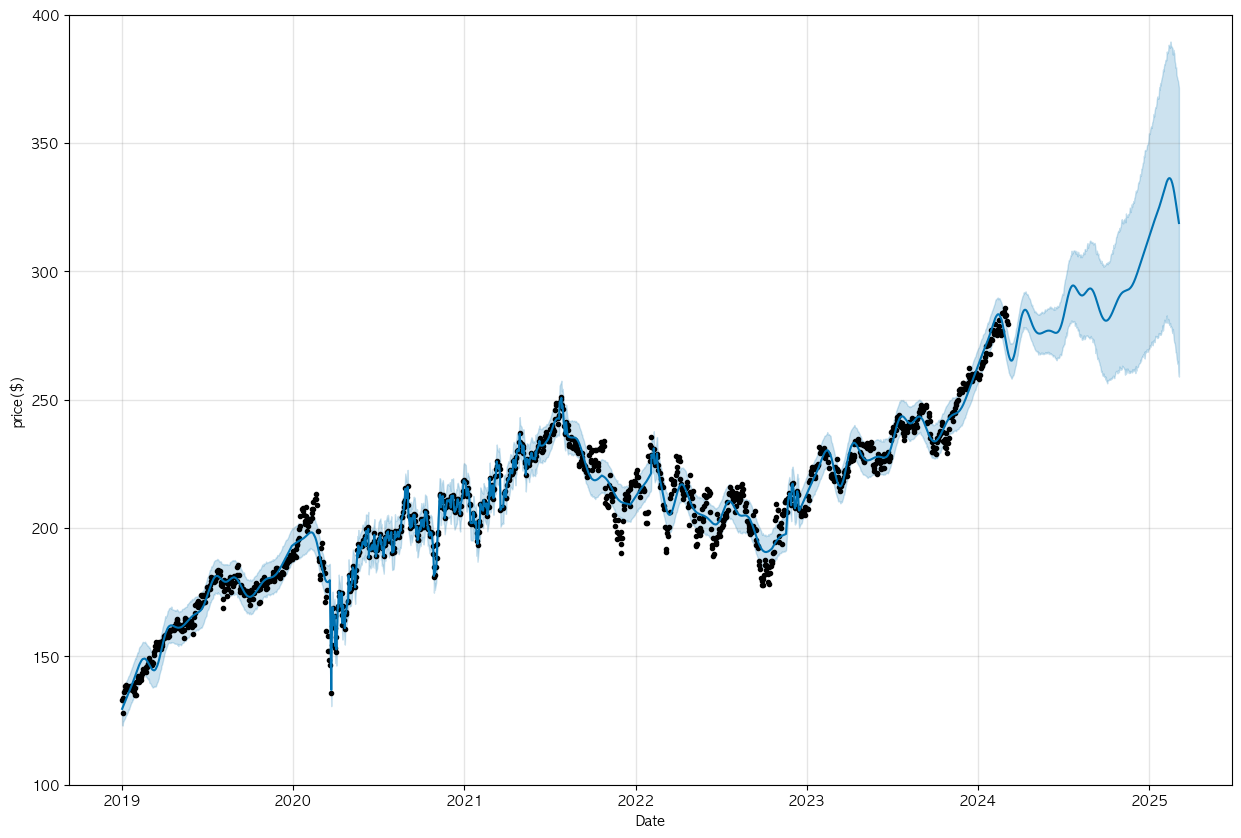

In [5]:
## model_prophet.plot(df_forecast)
# prophet github에서 plot 함수를 가져와서 작업

figsize=(15, 10)
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

m = model_prophet
# fcst_t = df_forecast['ds'].dt.to_pydatetime()
fcst_t = df_forecast['ds']
ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.', label='Observed data points')
ax.plot(fcst_t, df_forecast['yhat'], ls='-', c='#0072B2', label='Forecast')
ax.fill_between(fcst_t, df_forecast['yhat_lower'], df_forecast['yhat_upper'],
                color='#0072B2', alpha=0.2, label='Uncertainty interval')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)

xlabel='Date'
ylabel='price($)'
#ax.set_xlim(pd.to_datetime(['2023-06-01', '2024-12-31']))
ax.set_ylim(100,400)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.legend(labels=['실제 종가', '예측 종가', '최소/최대 예측 종가 범위'], fontsize=20, loc='center left', bbox_to_anchor=(-0.5,0.5))

#### 모델이 학습한 최근 5년간의 visa 주식 trend

- trend:전체적으로 우상향
- holiday: 코로나 시기인 2020년도는 진폭이 잦은 시기, trend 그래프에서도 감소하는 영향을 끼침
- yearly (연간 주기적인 영향): y=0을 기준으로, 1월부터 3월, 7,8월은 trend에 증가하는 영향 / 5,6월과 9월부터 12월 초까지는 trend에서 감소하는 영향이 있다고 학습됨
- daily: 인풋 데이터가 일자 데이터이므로 시간대는 의미 없으므로 무시해도 됨


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

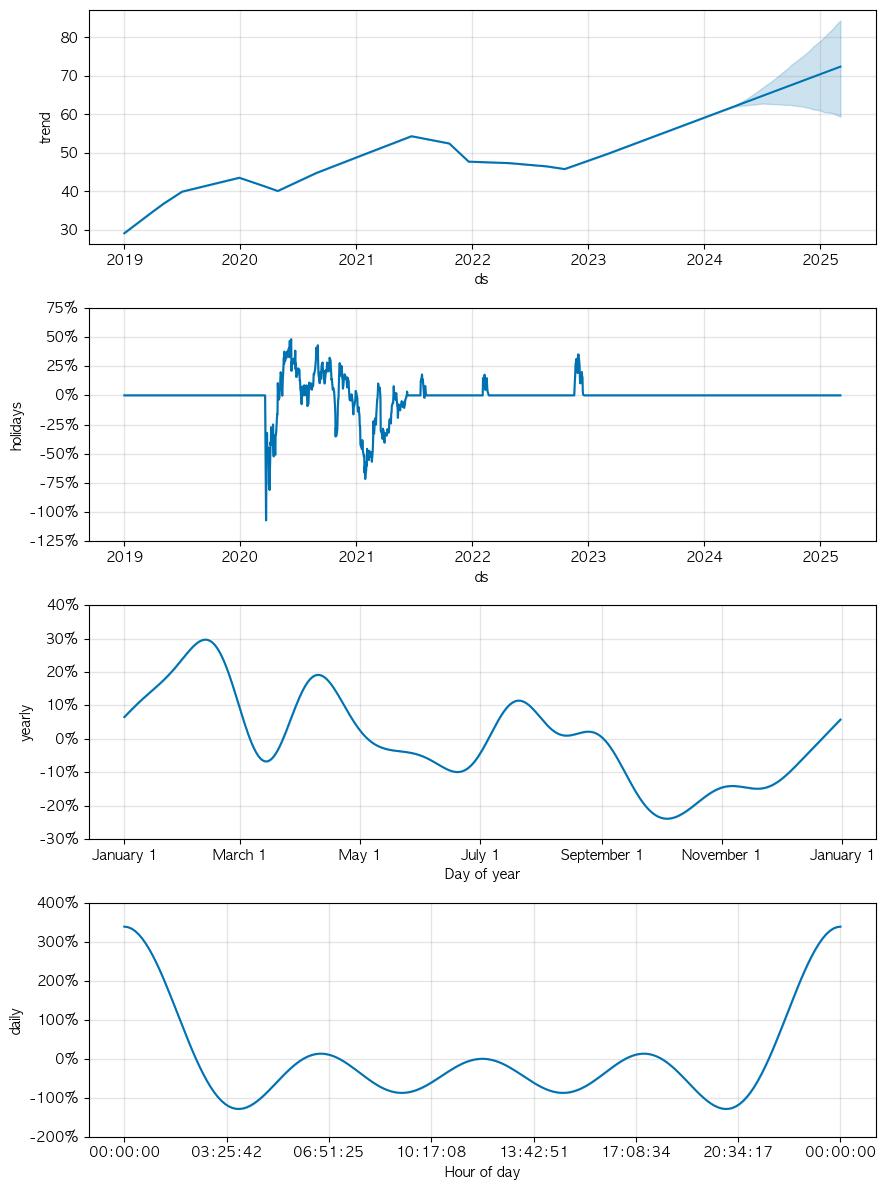

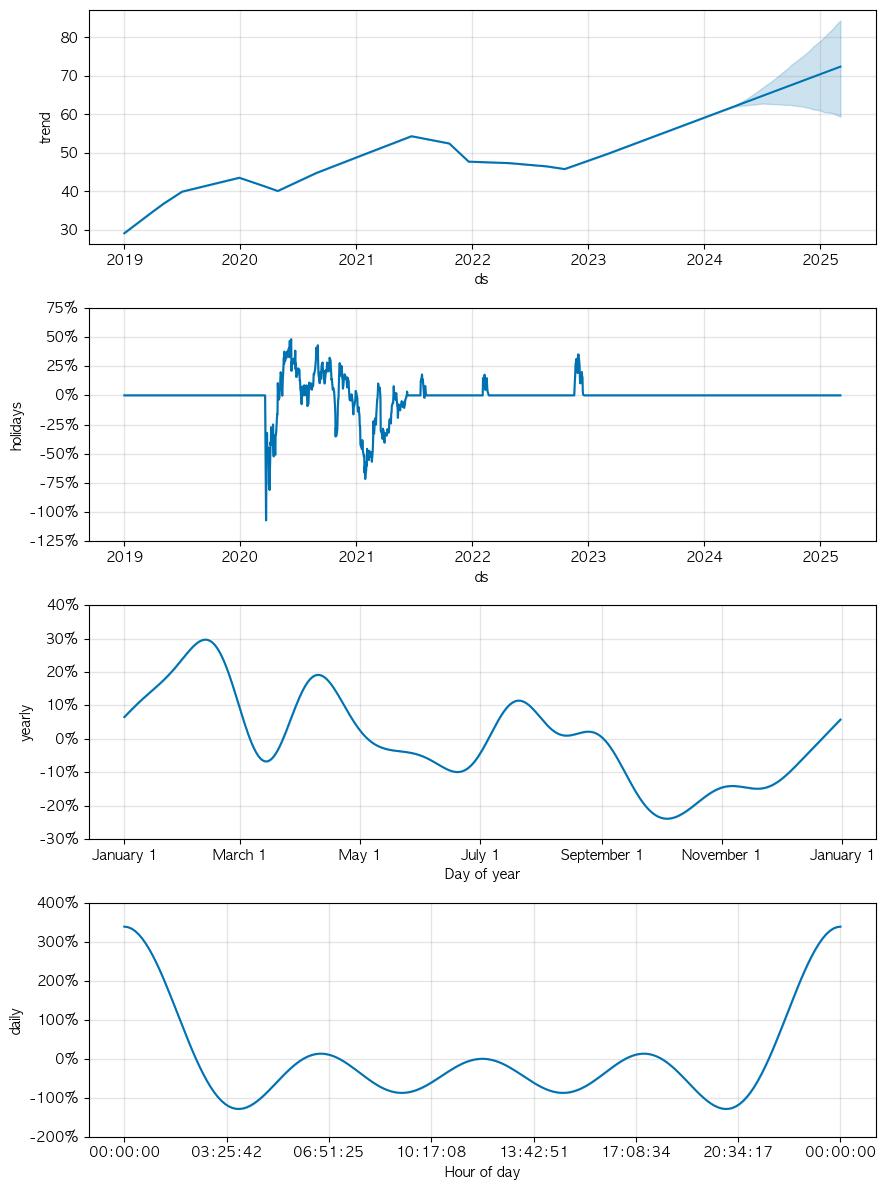

In [6]:
model_prophet.plot_components(df_forecast)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


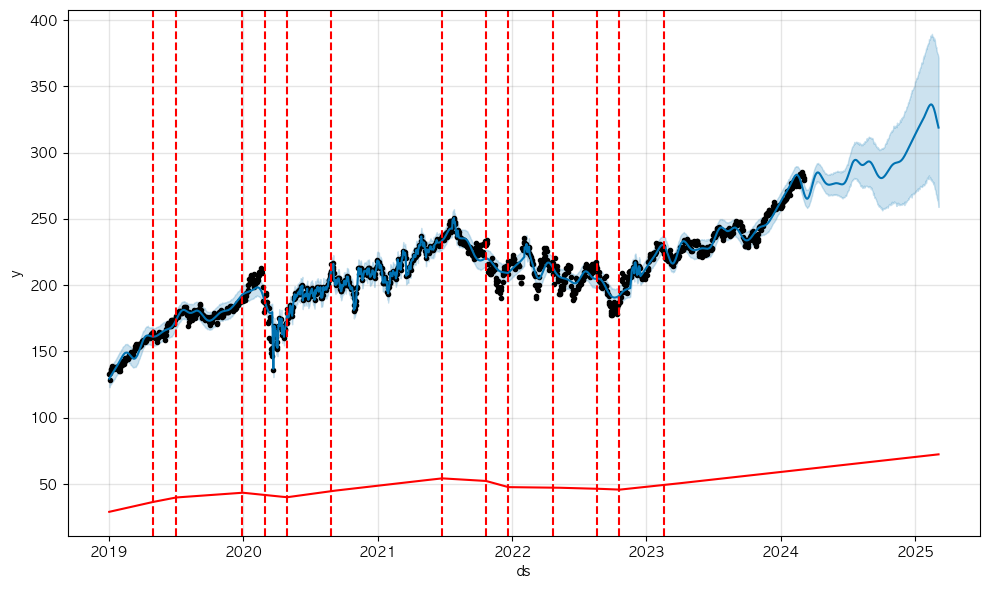

In [7]:
# 변동점 추출
from prophet.plot import add_changepoints_to_plot
fig = model_prophet.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model_prophet, df_forecast)

In [8]:
model_prophet.changepoints[np.abs(np.nanmean(model_prophet.params['delta'], axis=0)) >= 0.01]

83     2019-05-02
125    2019-07-02
250    2019-12-30
291    2020-02-28
333    2020-04-29
416    2020-08-26
624    2021-06-24
707    2021-10-21
749    2021-12-21
832    2022-04-21
915    2022-08-19
957    2022-10-19
1040   2023-02-17
Name: ds, dtype: datetime64[ns]

# 교차 검증

모델 성능 평가를 위해서, 
**코로나 상황을 고려한** 19년도부터 21년도, 3년치 데이터를 학습하여 
그 이후를 예측한 결과와 실제 데이터로부터 모델의 성능을 검증

- yearly seasonality 결과에서 약 3개월씩 비슷한 경향을 띄었던 것을 기반으로, **한 분기인 90일씩 예측 성능을 검증**

In [43]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model_prophet, initial='1085 days', period='91.25 days', horizon = '91.25 days')
# initial: 학습 기간/ period: 예측 기간 간격 (cutoff의 간격) / horizon: 예측 기간 단위(범위)
## 학습한 model_prophet을 기반으로 -> 1085일치를 학습하여, 91.25일마다 91.25일치씩 예측함
# 제일 최근 데이터가 2024-03-07이므로 이 때부터 90일씩 분기를 나누는듯함
# 3년은 1095일이지만 검증 기간을 2022-03-06으로 해주기 위해 1085일을 학습함
# 윤년이 포함되어 한 분기를 91.25일로 설정함 (90일도 가능하나 91.25를 권장하는 문구가 출력됨)

  0%|          | 0/8 [00:00<?, ?it/s]

14:44:06 - cmdstanpy - INFO - Chain [1] start processing
14:44:09 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:03<00:26,  3.83s/it]14:44:10 - cmdstanpy - INFO - Chain [1] start processing
14:44:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:08<00:24,  4.05s/it]14:44:14 - cmdstanpy - INFO - Chain [1] start processing
14:44:17 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:11<00:19,  3.83s/it]14:44:18 - cmdstanpy - INFO - Chain [1] start processing
14:44:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 4/8 [00:16<00:17,  4.30s/it]14:44:23 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▎   | 5/8 [00:21<00:13,  4.37s/it]14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:32 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 6/8 [00:27<00:09,  4.89s/it]14:44:33 - cmdstanpy - INFO - Chain [1] start proces

In [11]:
# period로 나누어진 예측할 기간들 (시작점)
## 2022-03-06부터 91.25일 (horizon) 예측
df_cv.cutoff.unique()

<DatetimeArray>
['2022-03-06 00:00:00', '2022-06-05 06:00:00', '2022-09-04 12:00:00',
 '2022-12-04 18:00:00', '2023-03-06 00:00:00', '2023-06-05 06:00:00',
 '2023-09-04 12:00:00', '2023-12-04 18:00:00']
Length: 8, dtype: datetime64[ns]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


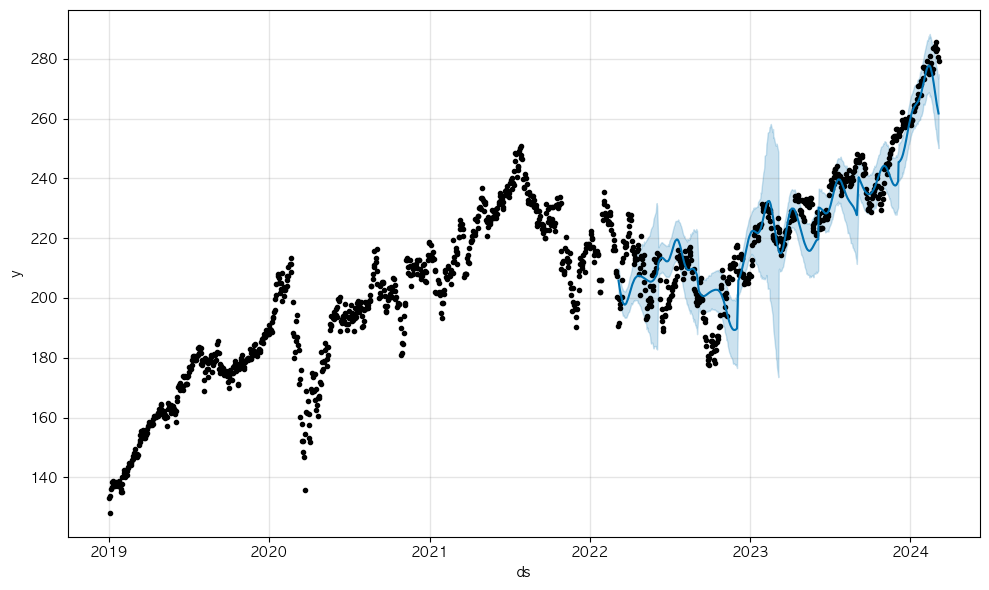

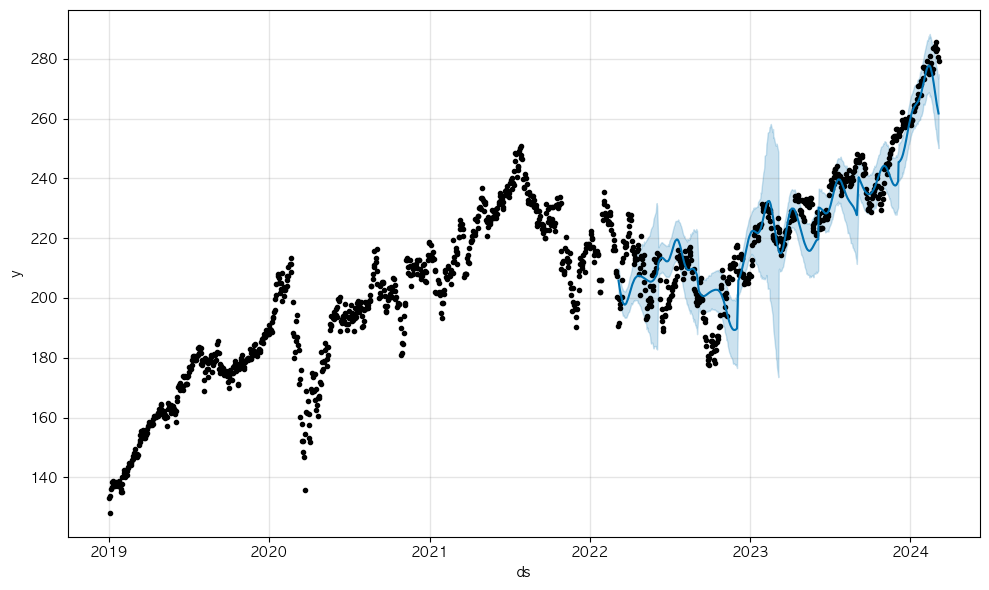

In [12]:
# initial=1085, period='91.25 days', horizon = '91.25 days'
model_prophet.plot(df_cv)

#### 교차검증 구간 확대
22년도에는 예측 범위를 벗어나는 실제 종가가 많이 보이며,
23년도에는 예측 범위 안에 주로 분포하는 것을 확인할 수 있음

/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/389223592.py:10: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.', label='Observed data points')


Text(0, 0.5, 'price($)')

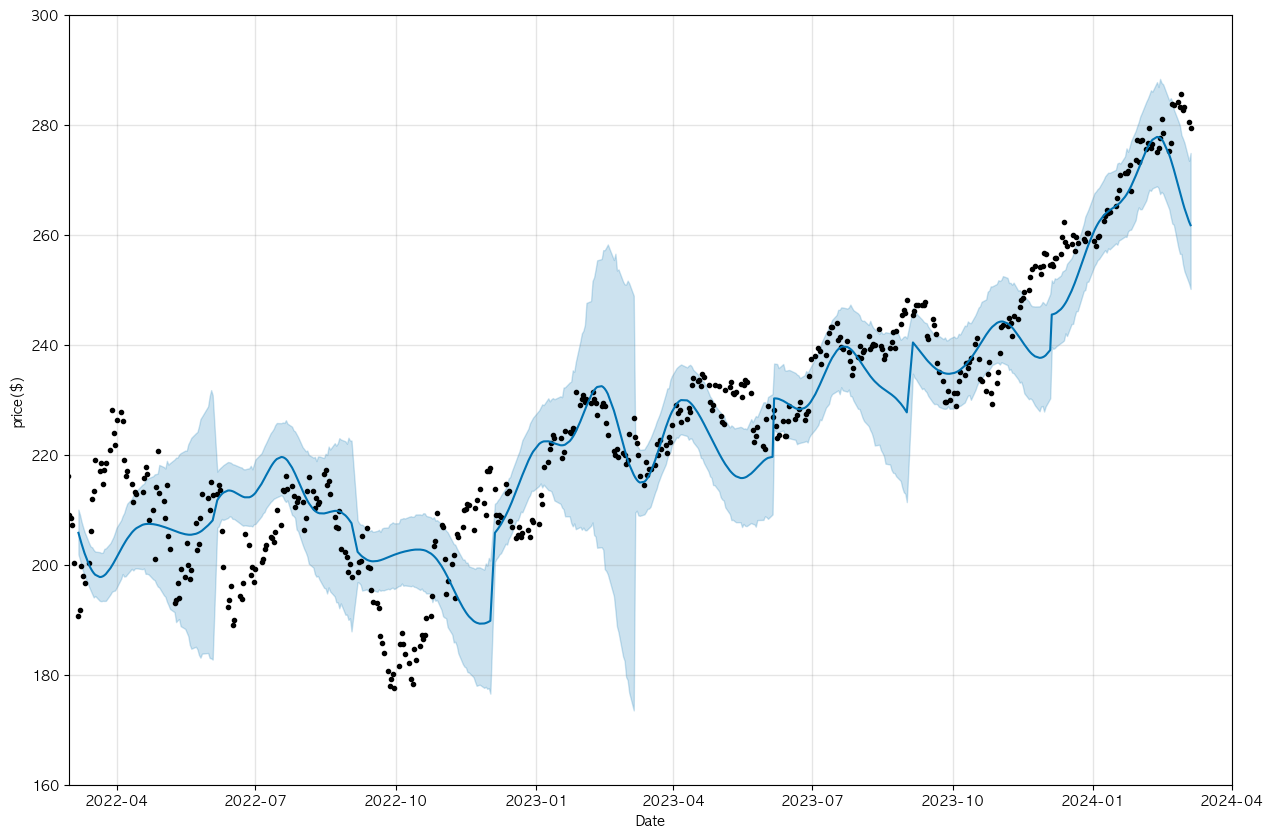

In [13]:
## model_prophet.plot(df_forecast)

figsize=(15, 10)
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

m = model_prophet
# fcst_t = df_forecast['ds'].dt.to_pydatetime()
fcst_t = df_cv['ds']
ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.', label='Observed data points')
ax.plot(fcst_t, df_cv['yhat'], ls='-', c='#0072B2', label='Forecast')
ax.fill_between(fcst_t, df_cv['yhat_lower'], df_cv['yhat_upper'],
                color='#0072B2', alpha=0.2, label='Uncertainty interval')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)

xlabel='Date'
ylabel='price($)'
ax.set_xlim(pd.to_datetime(['2022-03-01', '2024-04-01']))
ax.set_ylim(160,300)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.legend(labels=['실제 종가', '예측 종가', '최소/최대 예측 종가 범위'], fontsize=20, loc='center left', bbox_to_anchor=(-0.5,0.5))

### 교차 검증: 예측 종가와의 mse, rmse, mae

error가 손실/이익 -> rmse와 mae를 통해, 한 주당 평균 7 ~ 10달러의 손실 또는 이익을 얻을 수 있다고 해석할 수 있음


In [14]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=1) # rolling_window=1: 시뮬레이션된 모든 예측 지점에서 측정항목을 계산
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,101.670874,10.083198,7.734533,0.035471,0.026962,0.035558,0.61753


한 분기인 90일 동안의 error 분포가 희미한 회색점으로 나타나며, 파란 선은 그 평균
- plot_cross_validation_metric에서는 rolling_window=0.1로 평균(파란 선)을 그려줌 => window마다 10%씩 뽑아내어 평균 계산함

*<참고>*
- rolling_window=0.01: 각 window에서 df에 있는 행의 10%를 사용
- rolling_window=0: 각 horizon에 대해 별도로 계산
- rolling_window=-1: 메트릭은 평균화 없이 각 데이터 포인트에서 계산 (즉, 'mse'는 실제로 평균 없이 제곱 오류 값)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])

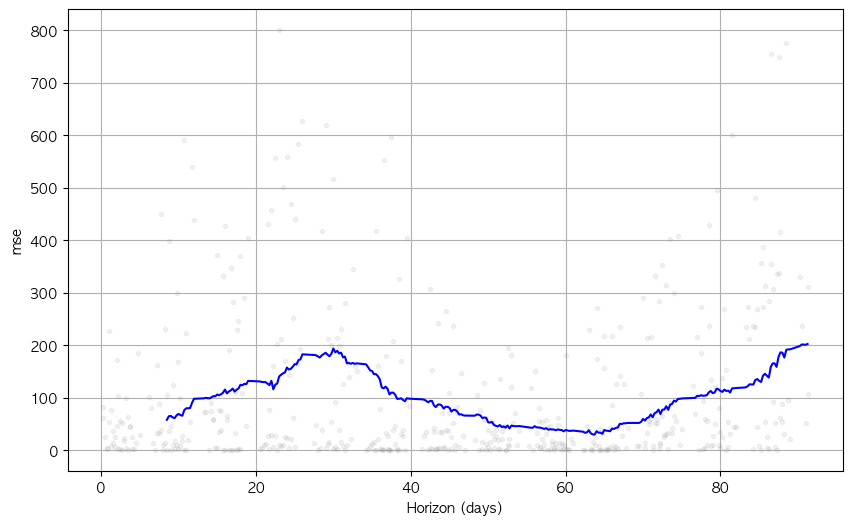

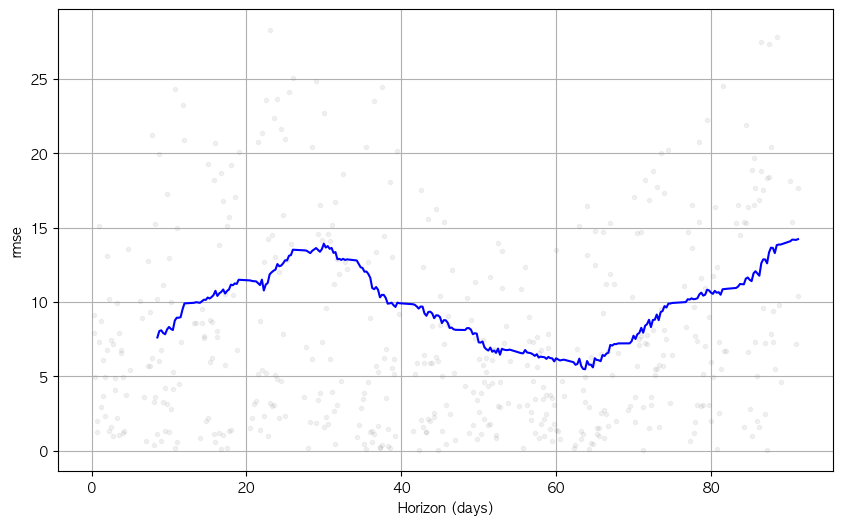

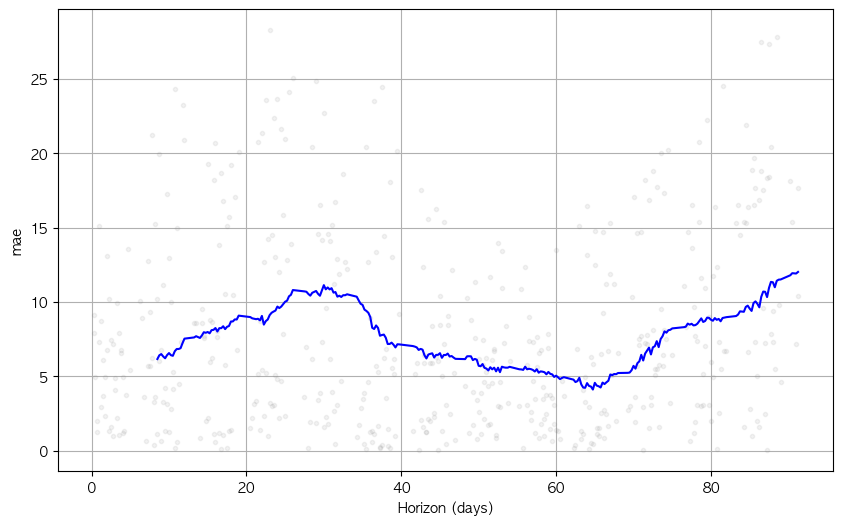

In [15]:
from prophet.plot import plot_cross_validation_metric
valid_metrics = ['mse', 'rmse', 'mae']
for metric in valid_metrics:
    fig = plot_cross_validation_metric(df_cv, metric=metric)

이 계산 방식은 **예측 범위**가 아닌 **예측 종가**로 계산 되는 문제 발생.

1. 예측 범위 안에 포함되는 것까지 고려해서 **최대최소 이익**을 계산할 것이므로 더 적절한 성능 지표가 필요함
2. 또한, 투자가 목적이므로! 코로나와 같은 예상치 못한 사태에서의 최대 손실을 고려할 수 있는 지표가 필요함

## 코로나 시기 교차 검증

우선적으로, 코로나를 겪기 이전 시기만을 학습하여, **동일한 교차 검증 실험** 진행
- 17 ~ 19년도, **3년치** 종가를 학습하였으며 holiday 파라미터는 *18년도의 올림픽과 월드컵*으로 변경

In [16]:
start_covid = '2017-01-01'
end_covid = '2021-12-31'
ticker='V'

df_covid = yf.download(ticker, start=start_covid, end=end_covid)
df_covid['ds'] = pd.to_datetime(df_covid.index, format='%Y-%m-%d')
df_covid['y'] = df_covid['Close']
df_covid = df_covid[['ds', 'y']]

event_covid = pd.DataFrame([
    {'holiday': 'olympic_winter', 'ds': '2018-02-09', 'lower_window': 0, 'ds_upper': '2018-02-25'},
    {'holiday': 'worldcup', 'ds': '2018-06-14', 'lower_window': 0, 'ds_upper': '2018-07-15'},
#    {'holiday': 'covid-19', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2021-06-10'},
#    {'holiday': 'olympic_summer', 'ds': '2021-07-23', 'lower_window': 0, 'ds_upper': '2021-08-08'},
#    {'holiday': 'olympic_winter', 'ds': '2022-02-04', 'lower_window': 0, 'ds_upper': '2022-02-20'},
#    {'holiday': 'worldcup', 'ds': '2022-11-20', 'lower_window':0, 'ds_upper': '2022-12-18'}
])
for t_col in ['ds', 'ds_upper']:
    event_covid[t_col] = pd.to_datetime(event_covid[t_col])
event_covid['upper_window'] = (event_covid['ds_upper'] - event_covid['ds']).dt.days
event_covid

[*********************100%%**********************]  1 of 1 completed


,holiday,ds,lower_window,ds_upper,upper_window
0,olympic_winter,2018-02-09,0,2018-02-25,16
1,worldcup,2018-06-14,0,2018-07-15,31


In [17]:
model_covid = Prophet(changepoint_prior_scale=0.05,
                      daily_seasonality=True,
                      weekly_seasonality=False,
                      yearly_seasonality=True,
                      seasonality_prior_scale=10.0,
                      seasonality_mode='multiplicative',
                      holidays=event,
                      #holidays_prior_scale=10,    # 휴일의 영향 정도 (조정 범위 [0.01,10]
                      )

model_covid.fit(df_covid)
df_covid_forecast = model_covid.make_future_dataframe(periods=365) 
df_covid_forecast = model_covid.predict(df_covid_forecast)

13:52:37 - cmdstanpy - INFO - Chain [1] start processing
13:52:42 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
df_covid_cv = cross_validation(model_covid, initial='1085 days', period='91.25 days', horizon = '91.25 days')

  0%|          | 0/8 [00:00<?, ?it/s]13:53:39 - cmdstanpy - INFO - Chain [1] start processing
13:53:42 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:03<00:22,  3.28s/it]13:53:43 - cmdstanpy - INFO - Chain [1] start processing
13:53:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:07<00:22,  3.81s/it]13:53:47 - cmdstanpy - INFO - Chain [1] start processing
13:53:50 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:11<00:19,  3.89s/it]13:53:51 - cmdstanpy - INFO - Chain [1] start processing
13:53:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 4/8 [00:14<00:14,  3.67s/it]13:53:54 - cmdstanpy - INFO - Chain [1] start processing
13:53:58 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▎   | 5/8 [00:19<00:12,  4.08s/it]13:53:59 - cmdstanpy - INFO - Chain [1] start processing
13:54:03 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 6/8 [00:24<00:08,  4.43s/it]13:54:04 - cmds

In [20]:
df_covid_cv.cutoff.unique()

<DatetimeArray>
['2019-12-31 00:00:00', '2020-03-31 06:00:00', '2020-06-30 12:00:00',
 '2020-09-29 18:00:00', '2020-12-30 00:00:00', '2021-03-31 06:00:00',
 '2021-06-30 12:00:00', '2021-09-29 18:00:00']
Length: 8, dtype: datetime64[ns]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


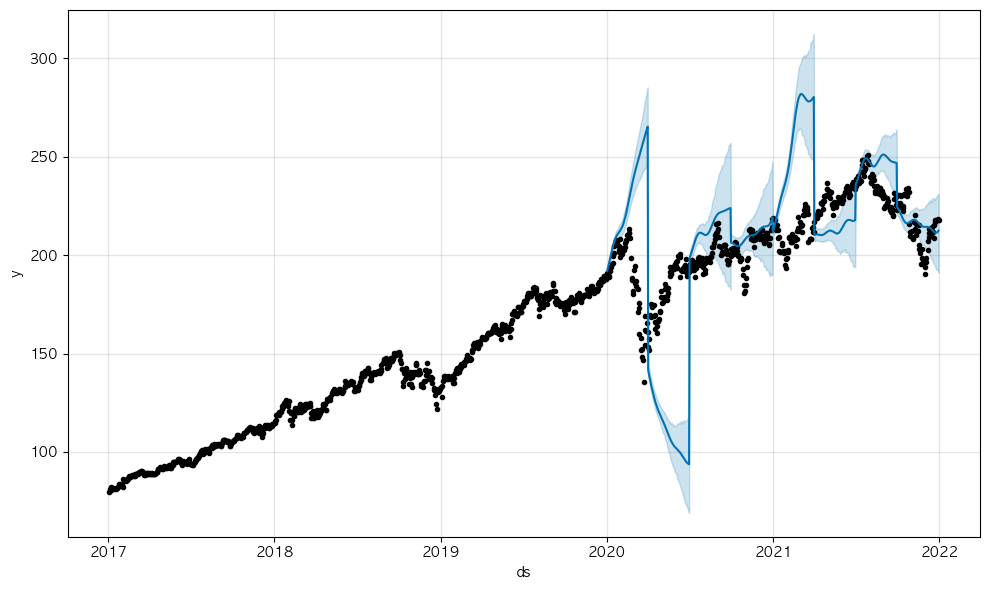

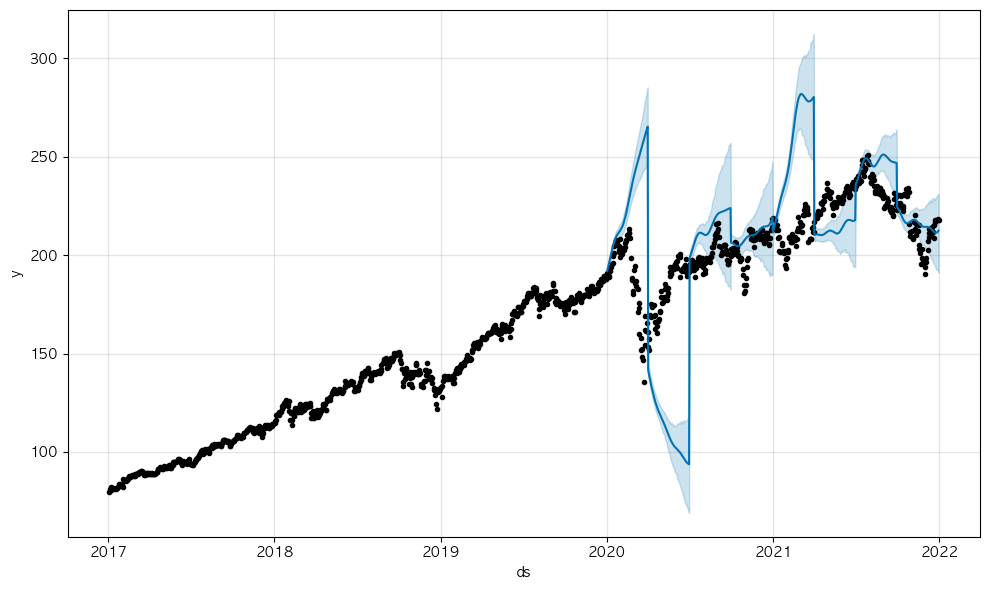

In [21]:
# initial=1085 days, period='91.25 days', horizon = '91.25 days'
# 코로나로 타격을 받은 2020년에서 모델의 예측이 완전히 빗나가는 것을 확인할 수 있음
model_covid.plot(df_covid_cv)

### 교차 검증 (코로나 예측 성능): 예측 종가와의 mse, rmse, mae
RMSE는 39.14, MAE는 26.73으로, 이 모델로 예측한 데이터로 20년도의 투자 결과를 예측했다면 **한 주당 평균적으로 약 27 ~ 39달러의 손해를 봤을 수도 있음**

In [22]:
df_covid_p = performance_metrics(df_covid_cv, rolling_window=1)
df_covid_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,1532.276345,39.144302,26.730907,0.137551,0.070848,0.141157,0.271825


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])

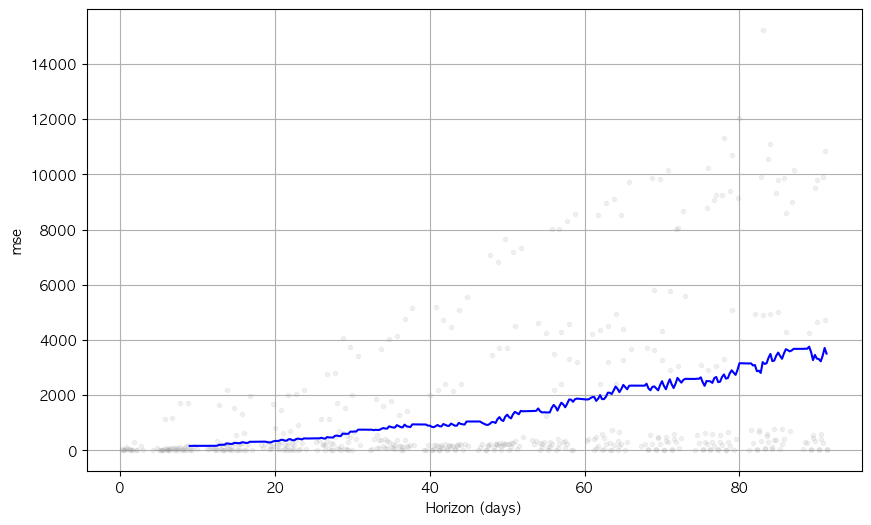

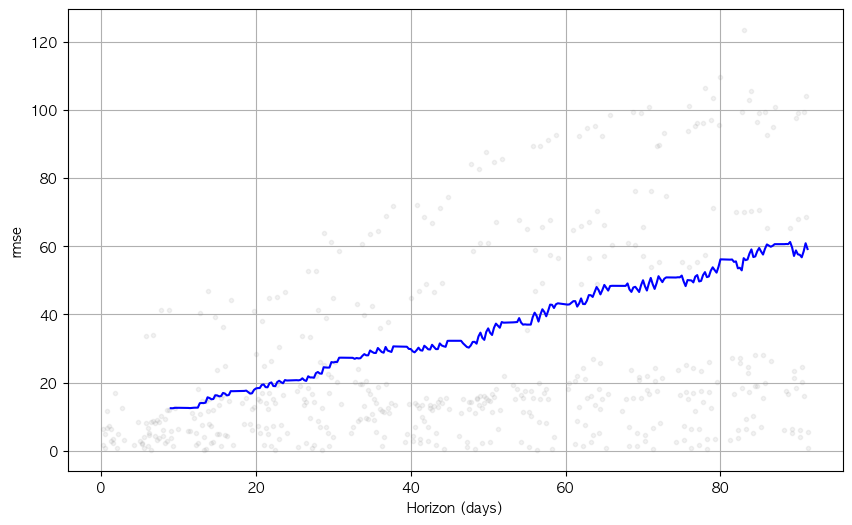

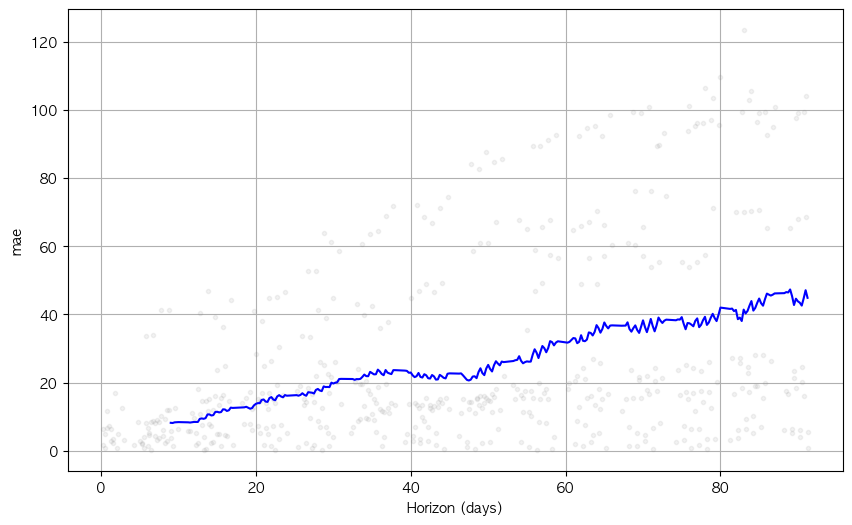

In [23]:
valid_metrics = ['mse', 'rmse', 'mae']
for metric in valid_metrics:
    fig = plot_cross_validation_metric(df_covid_cv, metric=metric)

#### 기존 모델 (최근 5년치 교차검증)과의 성능 비교

- covid 시기 예측 모델: rmse(39.14) mae(26.73)
- 기존 모델: rmse(10.08) mae(7.73)

예상치 못한 사태에서 error가 약 4배 정도 더 크게 발생

또한, **기존 모델**에서는 **분기 내에서 고르게 에러가 분포**하였지만,
**코로나 시기를 예측하는 모델**에서는 분기 말에 갈수록 예측을 크게 벗어면서 선 그래프가 **상승세**를 보임

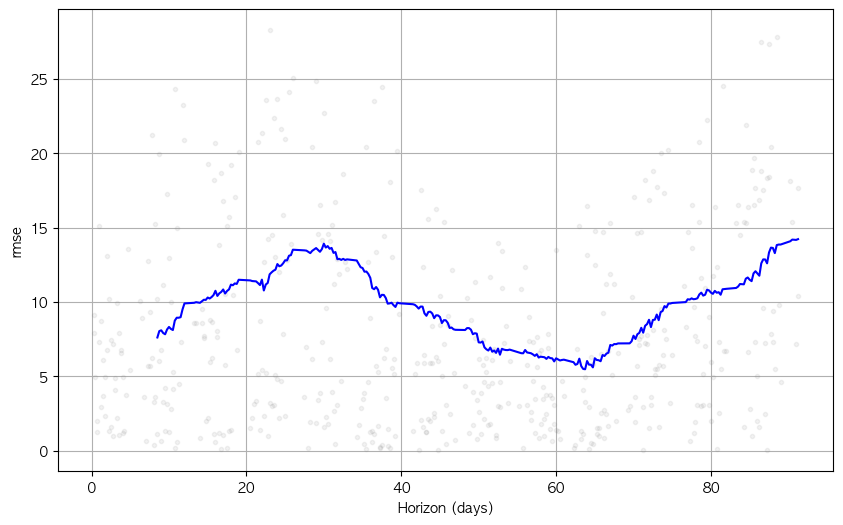
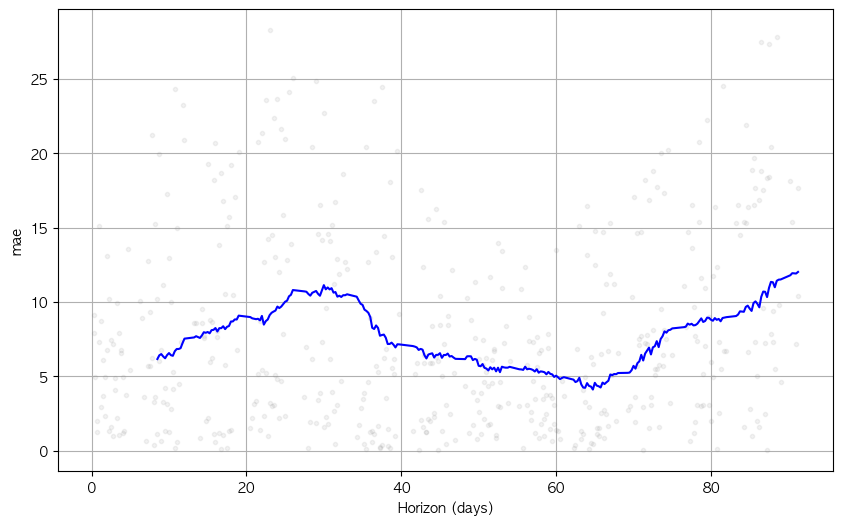

# 제안하는 지표: MUIE (Mean Uncertainty Interval Error)
0. 목적: 모델의 **예측 범위**를 이용하여 **최대/최소 수익을 예측**
1. rmse, mae와 비슷한 추세를 띄어, 같이 비교하여 해석할 수 있도록 구상
2. (투자가 목적이므로) 손실에 한해 가중치를 부여하여 더 큰 에러로 판단

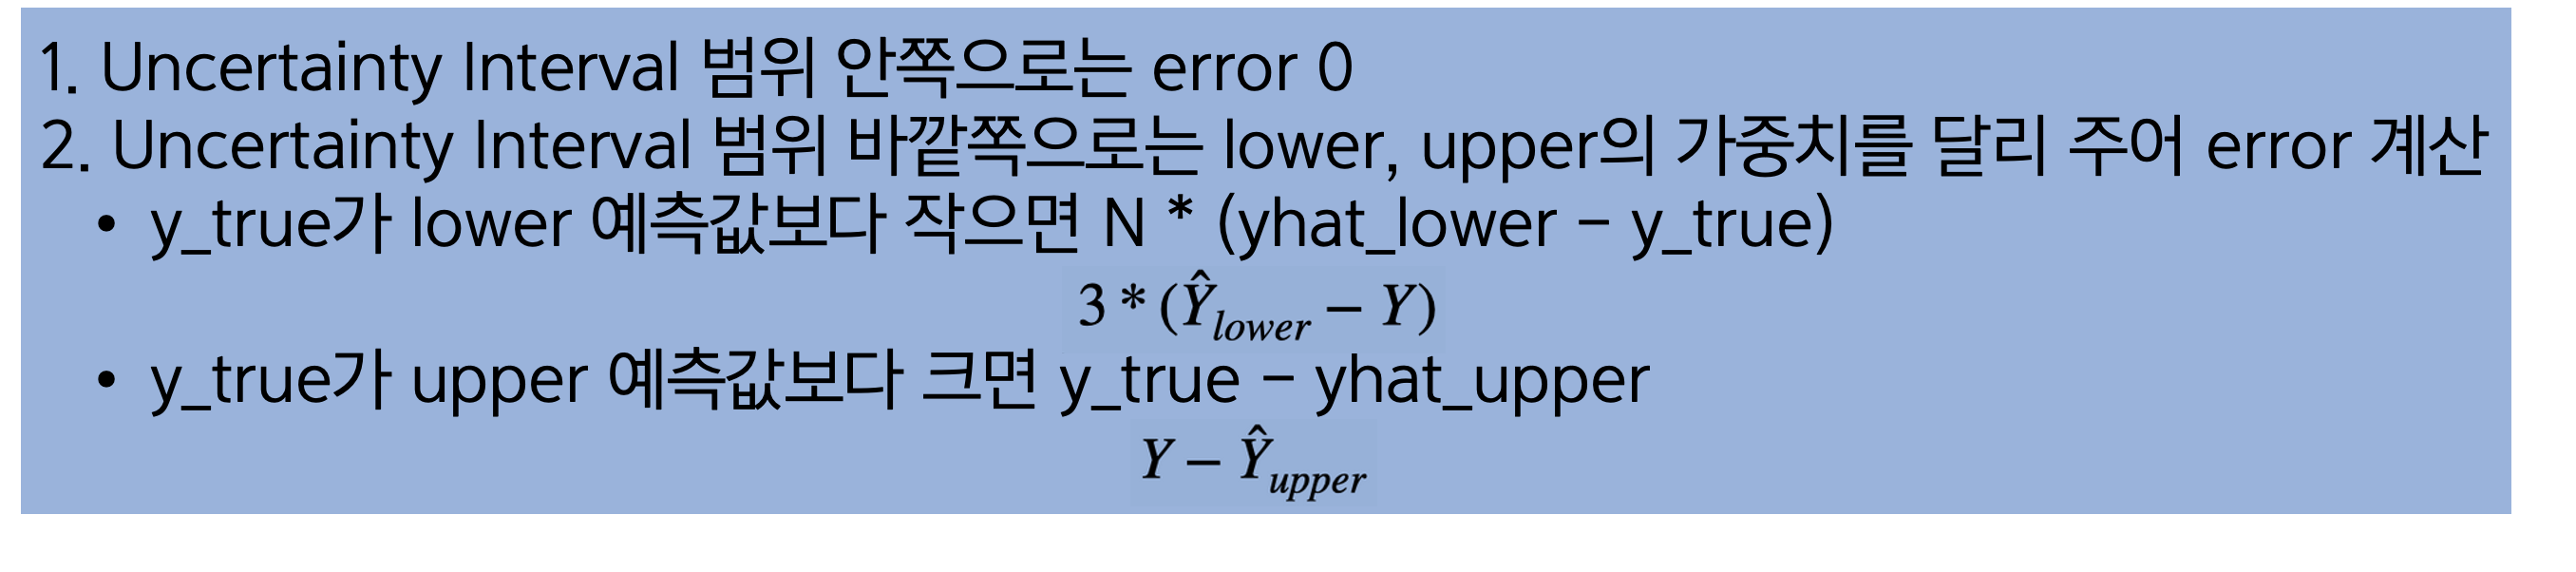

In [34]:
from prophet import diagnostics as diag

def performance_metrics(df, metrics=None, rolling_window=0.1, monthly=False):
    valid_metrics = ['muie', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'smape', 'coverage']
    if metrics is None:
        metrics = valid_metrics

    df_m = df.copy()
    if monthly:
        df_m['horizon'] = df_m['ds'].dt.to_period('M').astype(int) - df_m['cutoff'].dt.to_period('M').astype(int)
    else:
        df_m['horizon'] = df_m['ds'] - df_m['cutoff']
    df_m.sort_values('horizon', inplace=True)
    if 'mape' in metrics and df_m['y'].abs().min() < 1e-8:
        print('Skipping MAPE because y close to 0')
        metrics.remove('mape')
    if len(metrics) == 0:
        return None
    w = int(rolling_window * df_m.shape[0])
    if w >= 0:
        w = max(w, 1)
        w = min(w, df_m.shape[0])
    # Compute all metrics
    dfs = {}
    for metric in metrics:
        if metric == 'muie':
            dfs[metric] = eval(metric)(df_m, w)
        else:
            dfs[metric] = eval('diag.'+metric)(df_m, w)
    res = dfs[metrics[0]]
    for i in range(1, len(metrics)):
        res_m = dfs[metrics[i]]
        assert np.array_equal(res['horizon'].values, res_m['horizon'].values)
        res[metrics[i]] = res_m[metrics[i]]
    return res

def muie(df, w):
    """Mean Uncertainty Interval error

    Parameters
    ----------
    df: Cross-validation results dataframe.
    w: Aggregation window size.

    Returns
    -------
    Dataframe with columns horizon and mse.
    """
    uie = []
    for i, row in df.iterrows():
        ds, yhat, yhat_lower, yhat_upper, y_true, cutoff, horizon = row

        # uncertainty interval 범위를 벗어나면 예측의 upper/lower에서 subtract
        if y_true > yhat_upper:
            error = y_true - yhat_upper
        elif y_true < yhat_lower:
            error = 3 * (yhat_lower - y_true)   # 손실에 대한 가중치
        else:
            error = 0

        uie.append(error)

    if w < 0:
        return pd.DataFrame({'horizon': df['horizon'], 'muie': uie})
    return diag.rolling_mean_by_h(
        x=uie, h=df['horizon'].values, w=w, name='muie'
    )

In [27]:
def plot_cross_validation_metric(
    df_cv, metric, rolling_window=0.1, ax=None, figsize=(10, 6), color='b',
    point_color='gray'
):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Get the metric at the level of individual predictions, and with the rolling window.
    df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)   # 메트릭은 평균화 없이 각 데이터 포인트에서 계산 (즉, 'mse'는 실제로 평균 없이 제곱 오류 값)
    df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)  # 각 window에서 df에 있는 행의 10%를 사용 (0이면 각 horizon에 대해 별도로 계산)

    # Some work because matplotlib does not handle timedelta
    # Target ~10 ticks.
    tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for i, dt in enumerate(dts):
        if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
            break

    x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
    x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])   # 0.1 -> 각 window에서 df에 있는 행의 10%를 사용하여 평균 계산

    ax.plot(x_plt, df_none[metric], '.', alpha=0.1, c=point_color)
    ax.plot(x_plt_h, df_h[metric], '-', c=color)
    ax.grid(True)

    ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
    ax.set_ylabel(metric)
    #ax.set_ylim([-10, 130])

    ax.set_title(f'{metric.upper()} of cross_validation')
    return fig

#### 가중치 없이, 예측 범위를 벗어나는 경우에 절대값으로 error 계산
예측 범위 안에 들어오면 error가 0이므로, muie 그래프의 y=0 구간으로 error 분포가 내려간 것을 확인할 수 있음
- muie는 18.46으로 rmse & mae보다 작음
- ppt 발표자료를 만든 실험 때는 18.63 (매 실험마다 미세하게 차이가 있음)

In [30]:
df_covid_p = performance_metrics(df_covid_cv, rolling_window=1)
df_covid_p

,horizon,muie,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,18.464507,1532.276345,39.144302,26.730907,0.137551,0.070848,0.141157,0.271825


/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:37: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])   # 0.1 -> 각 window에서 df에 있는 행의 10%를 사용하여 평균 계산
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/

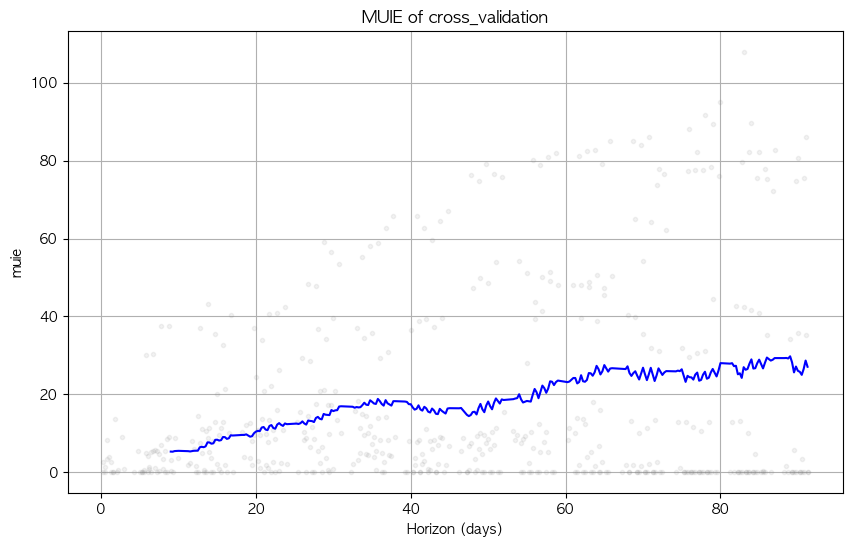

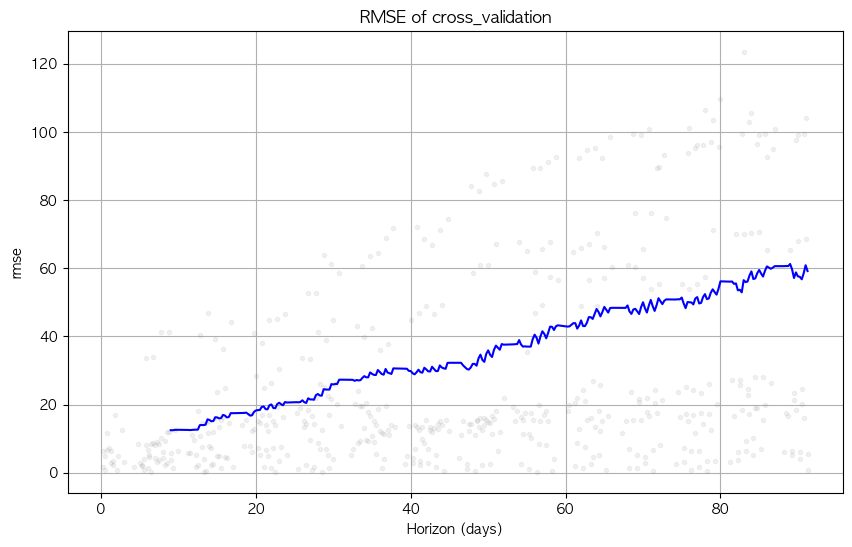

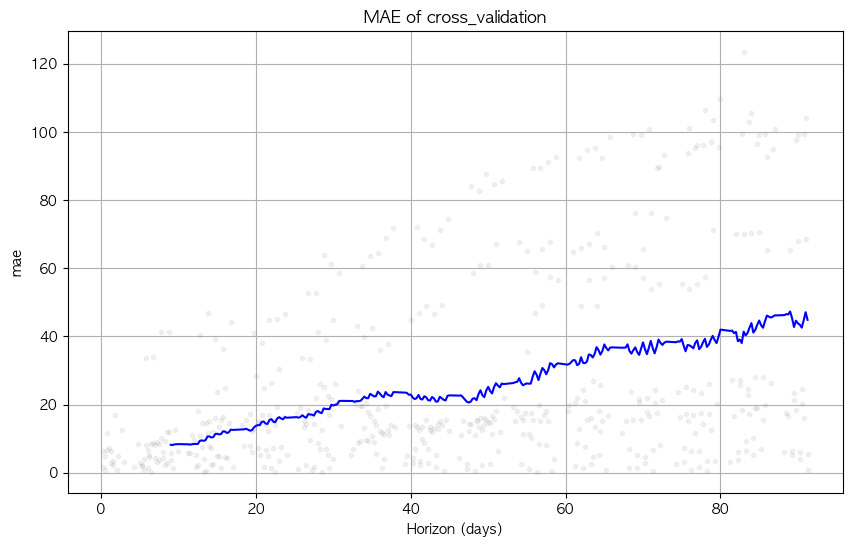

In [29]:
valid_metrics = ['muie', 'rmse', 'mae']
for metric in valid_metrics:
    fig = plot_cross_validation_metric(df_covid_cv, metric=metric)

#### 2배의 가중치: 예측 범위를 벗어나는 경우에 절대값으로 error 계산
- 28.14로 mae와 비슷한 평균값 
- 손실 error 데이터 점들이 가중치가 없을 때보다 올라온 것을 확인할 수 있음

In [32]:
df_covid_p = performance_metrics(df_covid_cv, rolling_window=1)
df_covid_p

,horizon,muie,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,28.14155,1532.276345,39.144302,26.730907,0.137551,0.070848,0.141157,0.271825


/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:37: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])   # 0.1 -> 각 window에서 df에 있는 행의 10%를 사용하여 평균 계산
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/

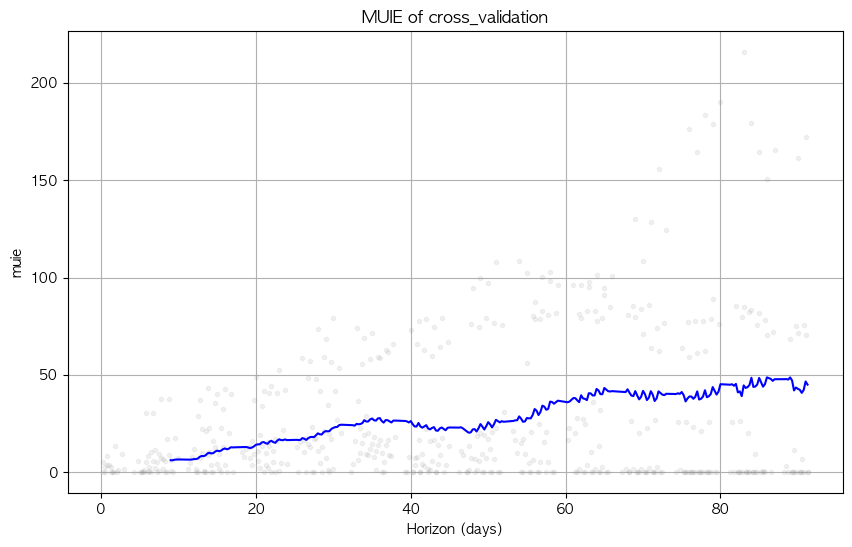

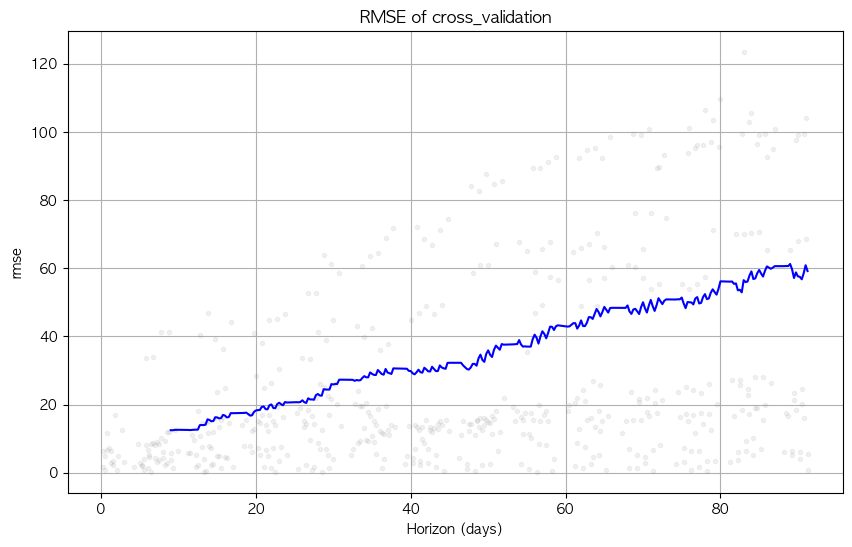

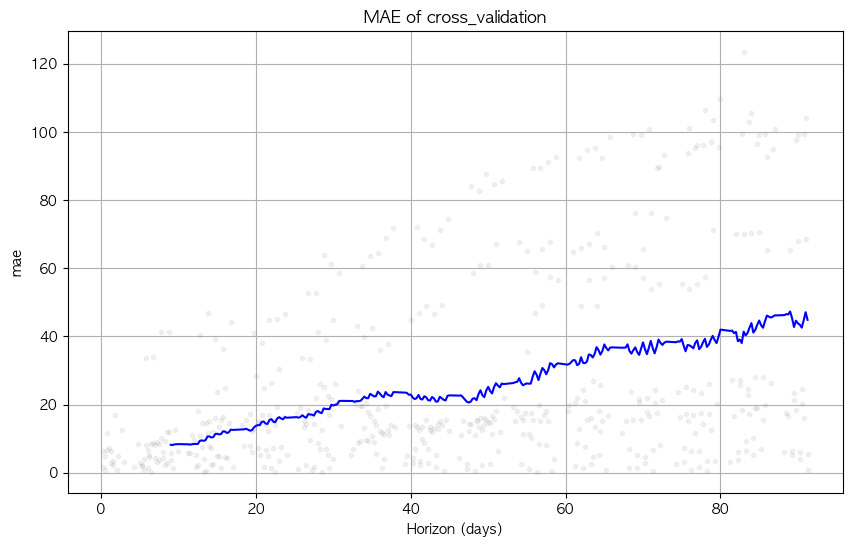

In [33]:
for metric in valid_metrics:
    fig = plot_cross_validation_metric(df_covid_cv, metric=metric)

#### 3배의 가중치: 예측 범위를 벗어나는 경우에 절대값으로 error 계산
- 37.81로 rmse와 비슷한 평균값 
- 손실 error 데이터가 더 강조되어, 평균 (파란 선)이 더욱 튀고 있음

In [35]:
df_covid_p = performance_metrics(df_covid_cv, rolling_window=1)
df_covid_p

,horizon,muie,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,37.818593,1532.276345,39.144302,26.730907,0.137551,0.070848,0.141157,0.271825


/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:37: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])   # 0.1 -> 각 window에서 df에 있는 행의 10%를 사용하여 평균 계산
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/

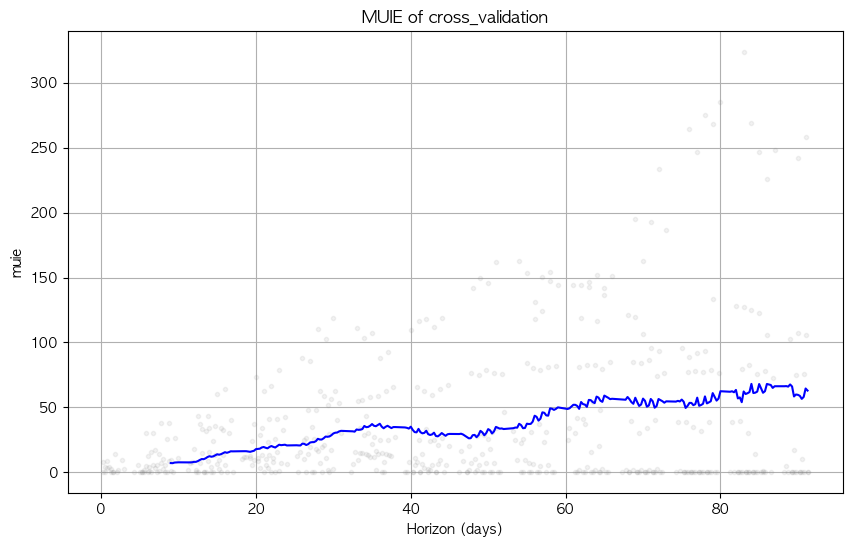

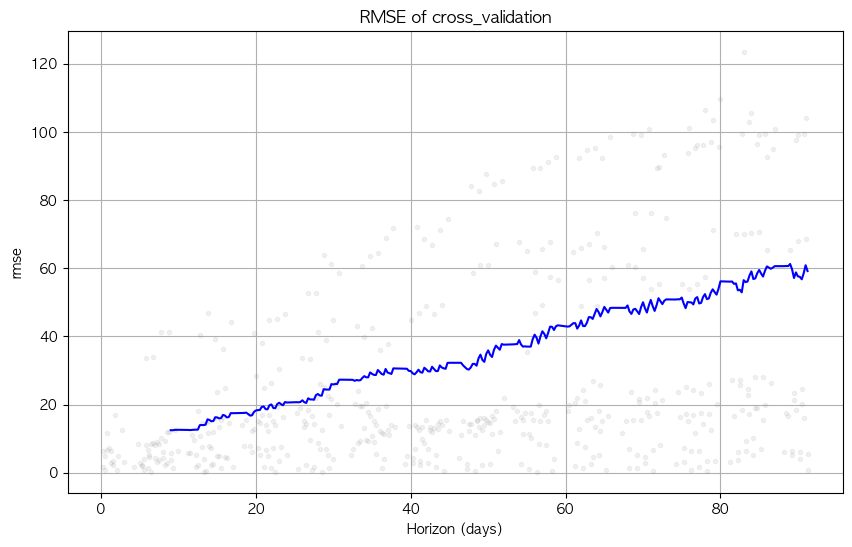

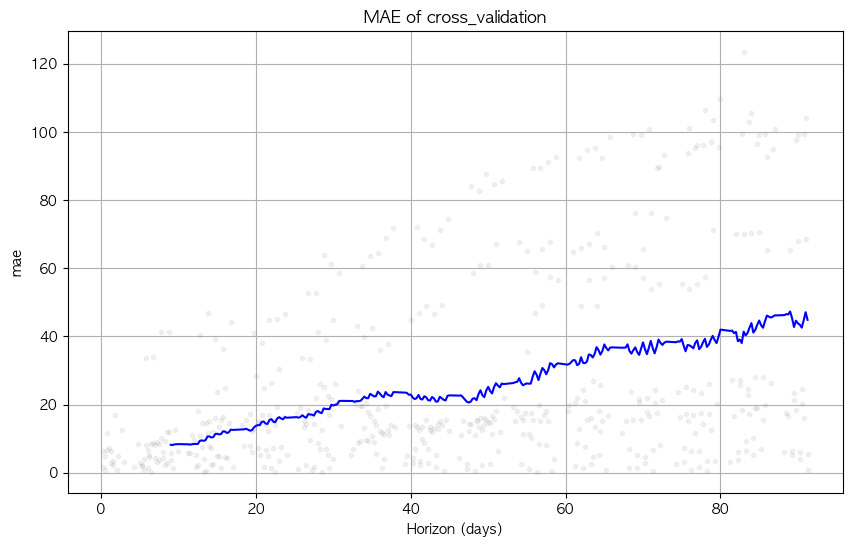

In [36]:
for metric in valid_metrics:
    fig = plot_cross_validation_metric(df_covid_cv, metric=metric)

### muie: 기존 모델과 covid 예측 모델 비교 분석
muie 지표룰 mae/rmse와 비교하면, **muie가 더 높으면 손실이 더욱 크고 muie가 더 낮으면 이익이 더 크거나 비슷하다고 판단** 가능

In [44]:
# 기존 모델
df_p = performance_metrics(df_cv, rolling_window=1) # rolling_window=1: 시뮬레이션된 모든 예측 지점에서 측정항목을 계산
df_p

,horizon,muie,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,5.353007,101.670874,10.083198,7.734533,0.035471,0.026962,0.035558,0.61753


In [42]:
# covid 예측 모델
df_covid_p

,horizon,muie,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,37.818593,1532.276345,39.144302,26.730907,0.137551,0.070848,0.141157,0.271825


- rmse 10.08과 mae 7.73과 비교하면 muie 5.35는 좀 더 낮은 수치
- 이를 통해, **실제 종가가 모델의 예측 범위 안**에 들어왔으며 **예측 결과에서 손실이 크지 않았다**고 이해할 수 있음

/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:37: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])   # 0.1 -> 각 window에서 df에 있는 행의 10%를 사용하여 평균 계산
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/

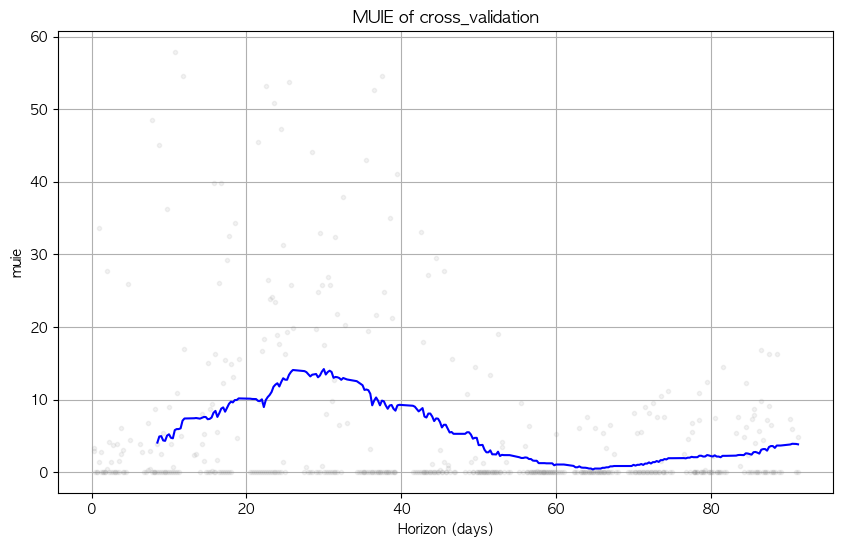

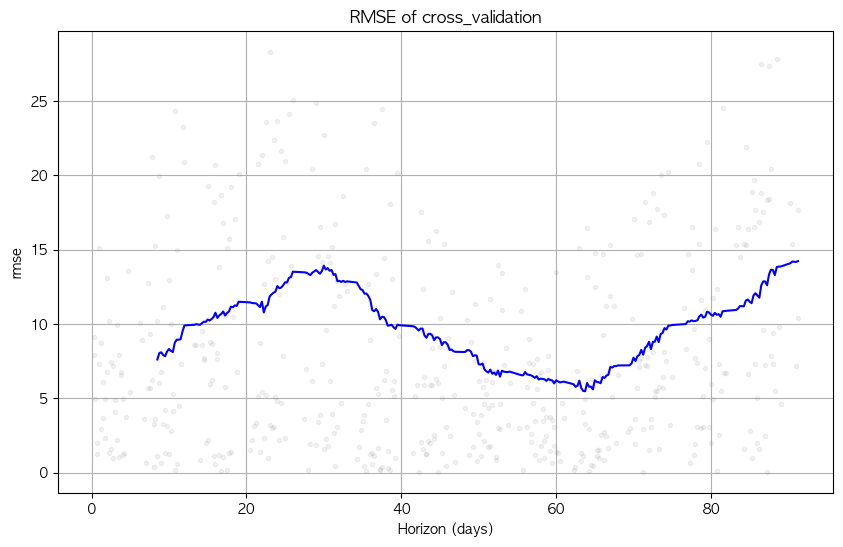

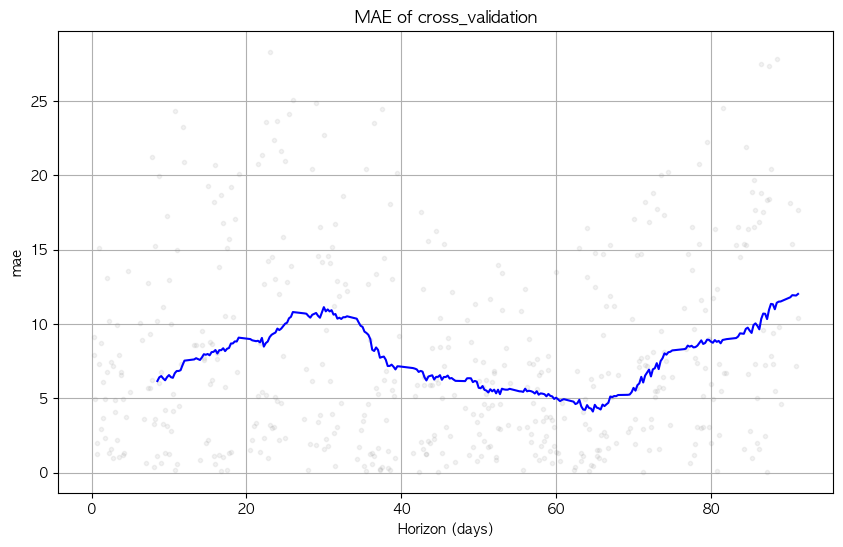

In [45]:
# 기존 모델
for metric in valid_metrics:
    fig = plot_cross_validation_metric(df_cv, metric=metric)

/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:37: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])   # 0.1 -> 각 window에서 df에 있는 행의 10%를 사용하여 평균 계산
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/

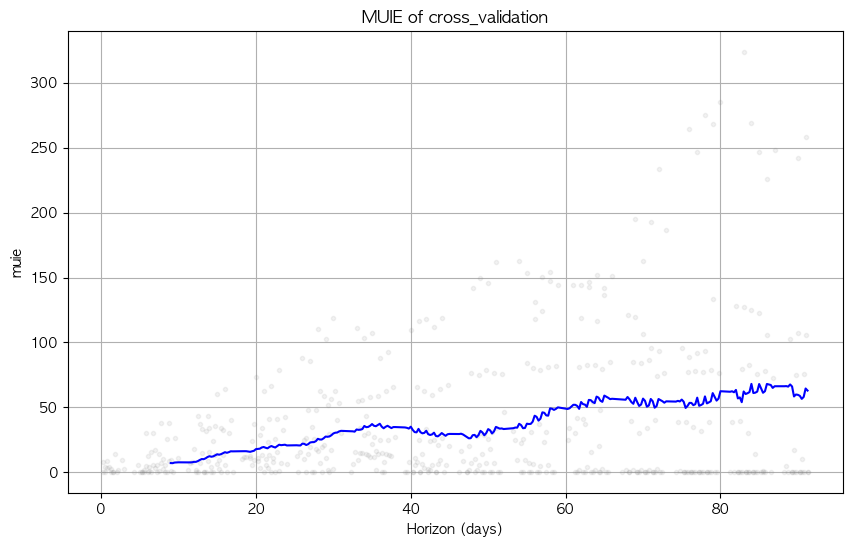

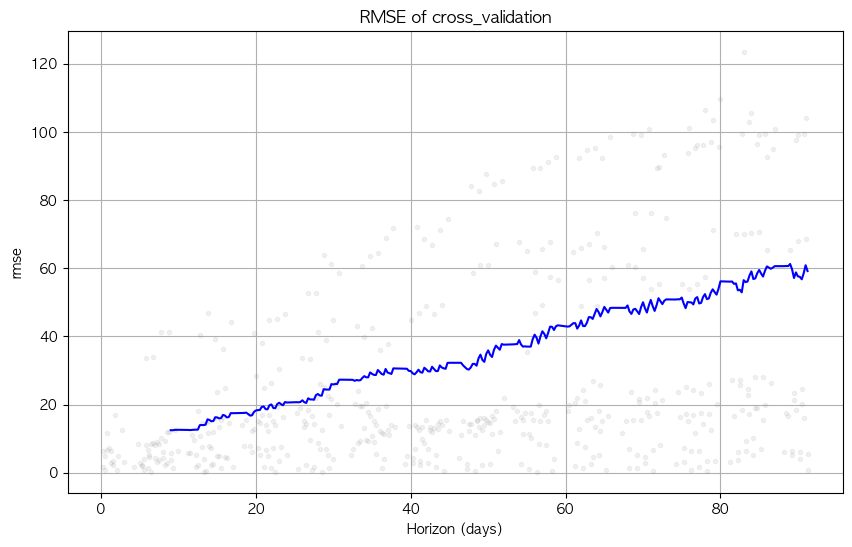

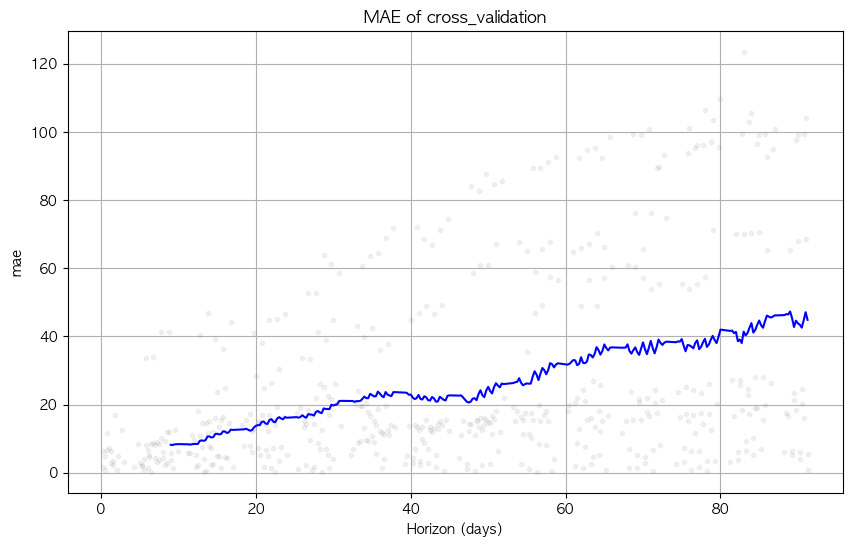

In [46]:
# covid 예측 모델
for metric in valid_metrics:
    fig = plot_cross_validation_metric(df_covid_cv, metric=metric)

# 하이퍼 파라미터 튜닝

In [37]:
import itertools

# 학습 기간: 최근 5년
start = '2019-01-01'
end = '2024-03-06'
ticker='V'

df = yf.download(ticker, start=start, end=end)
df['ds'] = pd.to_datetime(df.index, format='%Y-%m-%d')
df['y'] = df['Close']
df = df[['ds', 'y']]

event = pd.DataFrame([
    {'holiday': 'covid-19', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'olympic_summer', 'ds': '2021-07-23', 'lower_window': 0, 'ds_upper': '2021-08-08'},
    {'holiday': 'olympic_winter', 'ds': '2022-02-04', 'lower_window': 0, 'ds_upper': '2022-02-20'},
    {'holiday': 'worldcup', 'ds': '2022-11-20', 'lower_window':0, 'ds_upper': '2022-12-18'}
])
for t_col in ['ds', 'ds_upper']:
    event[t_col] = pd.to_datetime(event[t_col])
event['upper_window'] = (event['ds_upper'] - event['ds']).dt.days

# 최적의 파라미터 튜닝을 찾기 위해 실험해볼 파라미터 조합
param_grid = {  
    'changepoint_prior_scale': [0.20, 0.15, 0.10, 0.05],    # default 0.05
    'seasonality_prior_scale': [10.0, 1.0, 0.1, 0.05],  # 계절성의 영향 정도 (합리적인 조정 범위는 [0.01,10]), default 10
    'daily_seasonality': [True],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True],
    'seasonality_mode': ['multiplicative'],
    'holidays':[event],
    'holidays_prior_scale':[20.0, 10.0, 1.0, 0.5]   # default 10
}

# 실험할 파라미터의 모든 조합 생성
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
muies = []  # 파라미터 케이스마다 muie 측정값 저장

for params in all_params:
    model = Prophet(**params).fit(df)
    df_cv = cross_validation(model, initial='1085 days', period='91.25 days',horizon = '91.25 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1) # 시뮬레이션된 모든 예측 지점에서 측정항목을 계산
    muies.append(df_p['muie'].values[0])

# 최적의 parameter 조합 찾기
tuning_results = pd.DataFrame(all_params)
tuning_results['muie'] = muies

[*********************100%%**********************]  1 of 1 completed
14:18:54 - cmdstanpy - INFO - Chain [1] start processing
14:18:58 - cmdstanpy - INFO - Chain [1] done processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing
14:19:07 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing
14:19:09 - cmdstanpy - INFO - Chain [1] done processing
14:19:10 - cmdstanpy - INFO - Chain [1] done processing
14:19:10 - cmdstanpy - INF

In [38]:
tuning_results.sort_values('muie')

,changepoint_prior_scale,seasonality_prior_scale,daily_seasonality,weekly_seasonality,yearly_seasonality,seasonality_mode,holidays,holidays_prior_scale,muie
51,0.05,10.00,True,False,True,multiplicative,holiday ds lower_window d...,0.5,5.008628
50,0.05,10.00,True,False,True,multiplicative,holiday ds lower_window d...,1.0,5.025968
52,0.05,1.00,True,False,True,multiplicative,holiday ds lower_window d...,20.0,5.145930
53,0.05,1.00,True,False,True,multiplicative,holiday ds lower_window d...,10.0,5.180010
49,0.05,10.00,True,False,True,multiplicative,holiday ds lower_window d...,10.0,5.264618
...,...,...,...,...,...,...,...,...,...
8,0.20,0.10,True,False,True,multiplicative,holiday ds lower_window d...,20.0,8.615428
14,0.20,0.05,True,False,True,multiplicative,holiday ds lower_window d...,1.0,8.849981
9,0.20,0.10,True,False,True,multiplicative,holiday ds lower_window d...,10.0,8.903795
12,0.20,0.05,True,False,True,multiplicative,holiday ds lower_window d...,20.0,9.099020


In [39]:
best_params = all_params[np.argmin(muies)]

In [40]:
best_params

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 10.0,
 'daily_seasonality': True,
 'weekly_seasonality': False,
 'yearly_seasonality': True,
 'seasonality_mode': 'multiplicative',
 'holidays':           holiday         ds  lower_window   ds_upper  upper_window
 0        covid-19 2020-03-21             0 2021-06-10           446
 1  olympic_summer 2021-07-23             0 2021-08-08            16
 2  olympic_winter 2022-02-04             0 2022-02-20            16
 3        worldcup 2022-11-20             0 2022-12-18            28,
 'holidays_prior_scale': 0.5}

# best parameter로 학습한 모델 결과 시각화

In [47]:
model = Prophet(changepoint_prior_scale=0.05,
                daily_seasonality=True,
                weekly_seasonality=False,
                yearly_seasonality=True,
                seasonality_prior_scale=10.0,
                seasonality_mode='multiplicative',
                holidays=event,
                holidays_prior_scale=0.5)

model.fit(df)
df_forecast = model.make_future_dataframe(periods=365) 
df_forecast = model.predict(df_forecast)

14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing


/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1210167619.py:8: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(model.history['ds'].dt.to_pydatetime(), model.history['y'], 'k.', label='Observed data points')


Text(0, 0.5, 'price($)')

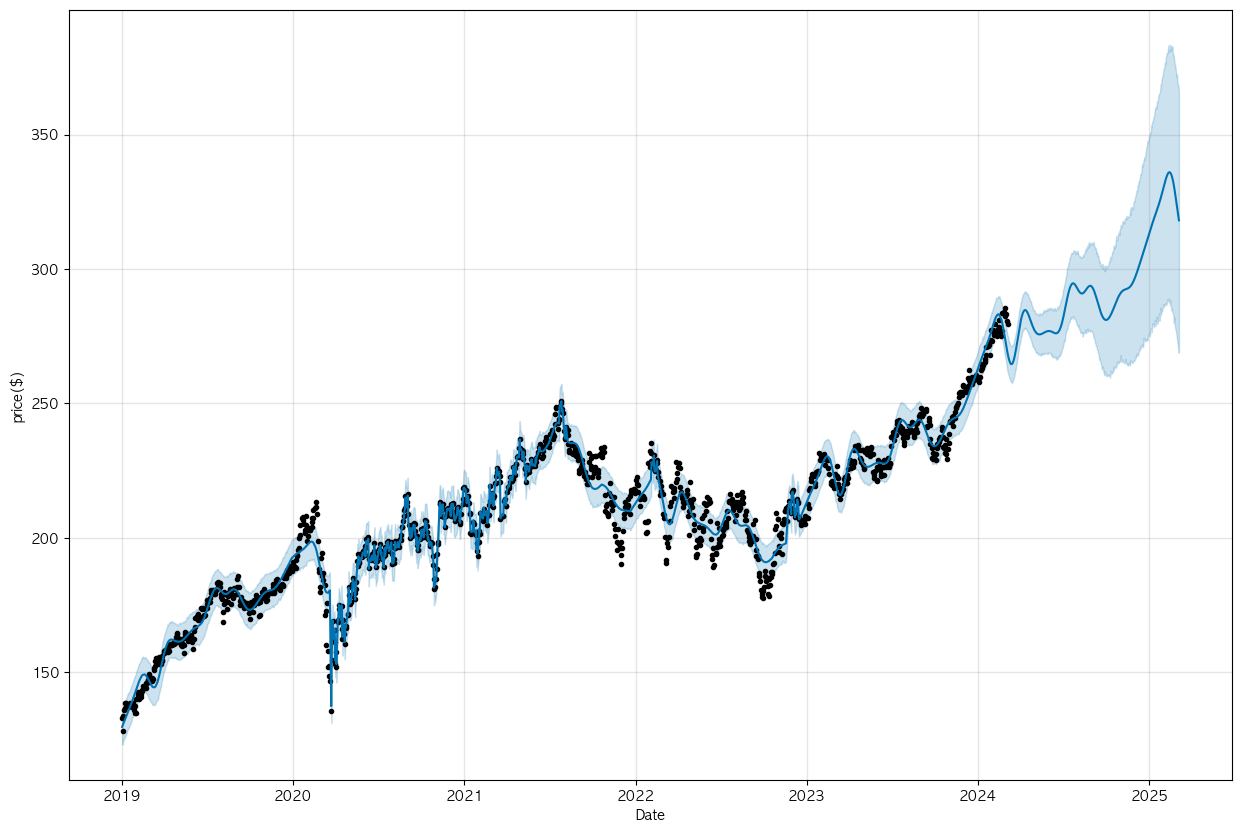

In [52]:
## model.plot(df_forecast)

figsize=(15, 10)
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

fcst_t = df_forecast['ds']
ax.plot(model.history['ds'].dt.to_pydatetime(), model.history['y'], 'k.', label='Observed data points')
ax.plot(fcst_t, df_forecast['yhat'], ls='-', c='#0072B2', label='Forecast')
ax.fill_between(fcst_t, df_forecast['yhat_lower'], df_forecast['yhat_upper'],
                color='#0072B2', alpha=0.2, label='Uncertainty interval')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)

xlabel='Date'
ylabel='price($)'
#ax.set_xlim(pd.to_datetime(['2023-06-01', '2024-12-31']))
#ax.set_ylim(100,400)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.legend()

/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/495020628.py:8: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(model.history['ds'].dt.to_pydatetime(), model.history['y'], 'k.', label='Observed data points')


Text(0, 0.5, 'price($)')

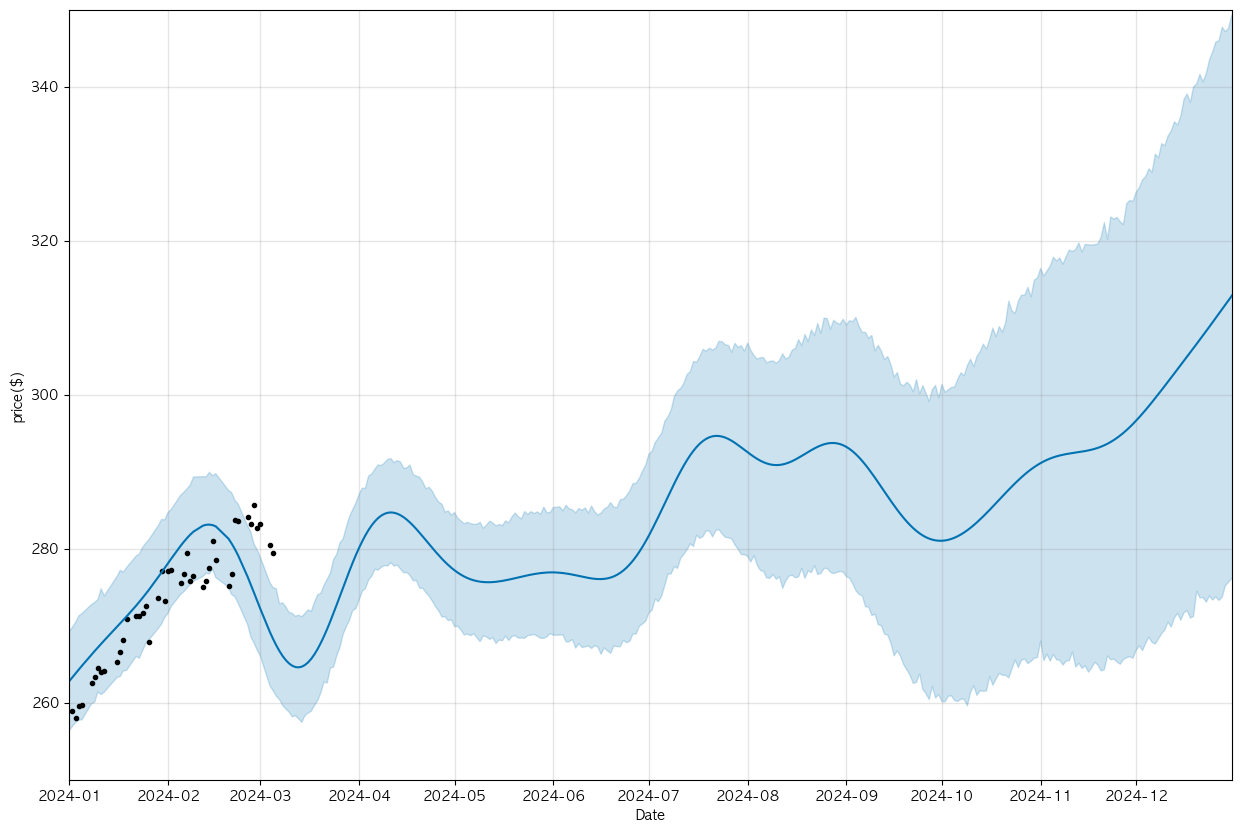

In [53]:
## model.plot(df_forecast)

figsize=(15, 10)
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

fcst_t = df_forecast['ds']
ax.plot(model.history['ds'].dt.to_pydatetime(), model.history['y'], 'k.', label='Observed data points')
ax.plot(fcst_t, df_forecast['yhat'], ls='-', c='#0072B2', label='Forecast')
ax.fill_between(fcst_t, df_forecast['yhat_lower'], df_forecast['yhat_upper'],
                color='#0072B2', alpha=0.2, label='Uncertainty interval')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)

xlabel='Date'
ylabel='price($)'
ax.set_xlim(pd.to_datetime(['2024-01-01', '2024-12-31']))
ax.set_ylim(250,350)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.legend()

1. 현재, 2024년 3월은 **하락세를 보이다 상승세**를 타는 시기 (변동점)
2. 4월이 되기 전에 상승세가 시작되므로, **이 최저점을 매수 시기**로 판단.
3. 매수 시기를 기준으로 했을 때, **올해 여름인 7월 부터 9월이 휴가 시즌과 올림픽의 영향으로 고점이 예상**
    - 이후 데이터는 예측 범위가 넓어지므로, 단기 투자를 생각했을 때는 올해 여름이 적절할 것

## [참고] 추가 교차 검증: 최종 모델

In [54]:
df_cv = cross_validation(model, initial='1085 days', period='91.25 days',horizon = '91.25 days')

  0%|          | 0/8 [00:00<?, ?it/s]14:47:18 - cmdstanpy - INFO - Chain [1] start processing
14:47:21 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:02<00:19,  2.75s/it]14:47:21 - cmdstanpy - INFO - Chain [1] start processing
14:47:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:05<00:15,  2.65s/it]14:47:24 - cmdstanpy - INFO - Chain [1] start processing
14:47:26 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:07<00:12,  2.56s/it]14:47:26 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 4/8 [00:13<00:14,  3.61s/it]14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▎   | 5/8 [00:16<00:10,  3.39s/it]14:47:34 - cmdstanpy - INFO - Chain [1] start processing
14:47:38 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 6/8 [00:20<00:07,  3.61s/it]14:47:38 - cmds

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


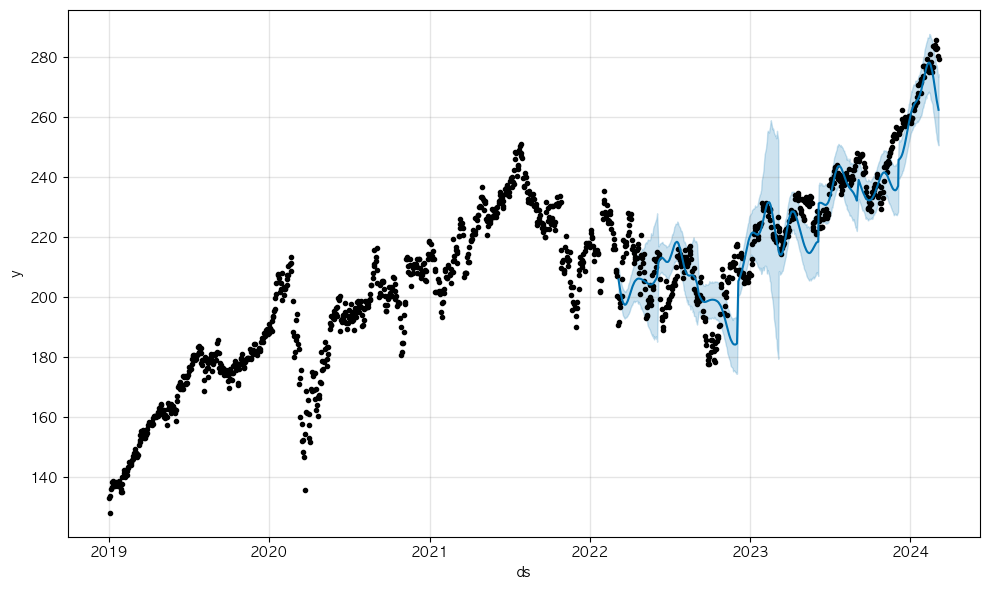

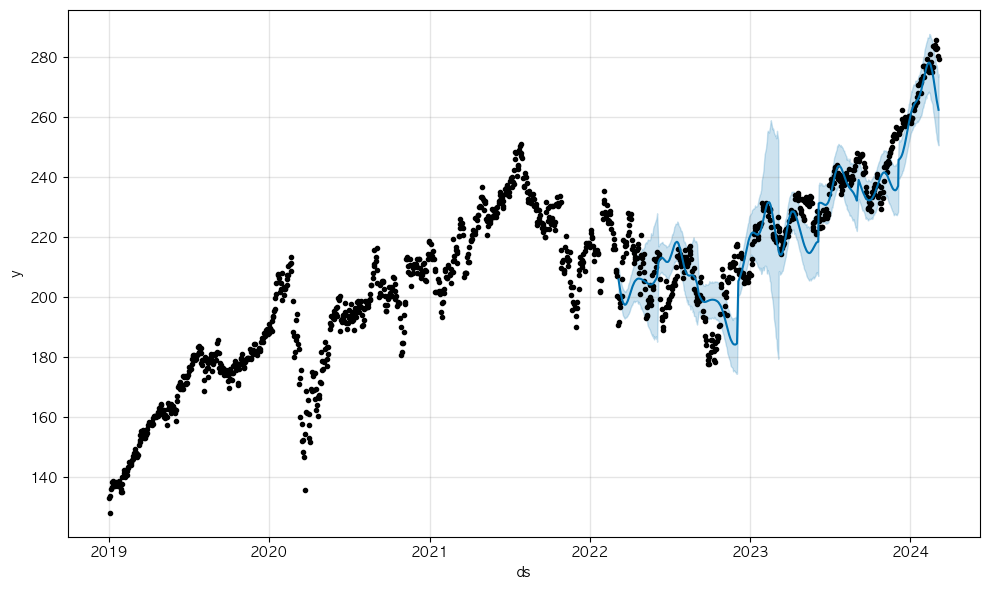

In [55]:
model.plot(df_cv)

In [56]:
performance_metrics(df_cv, rolling_window=1)

,horizon,muie,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days 06:00:00,5.056993,104.315748,10.213508,7.742755,0.035394,0.026021,0.035725,0.587649


/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:36: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_75375/1198668781.py:37: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])   # 0.1 -> 각 window에서 df에 있는 행의 10%를 사용하여 평균 계산


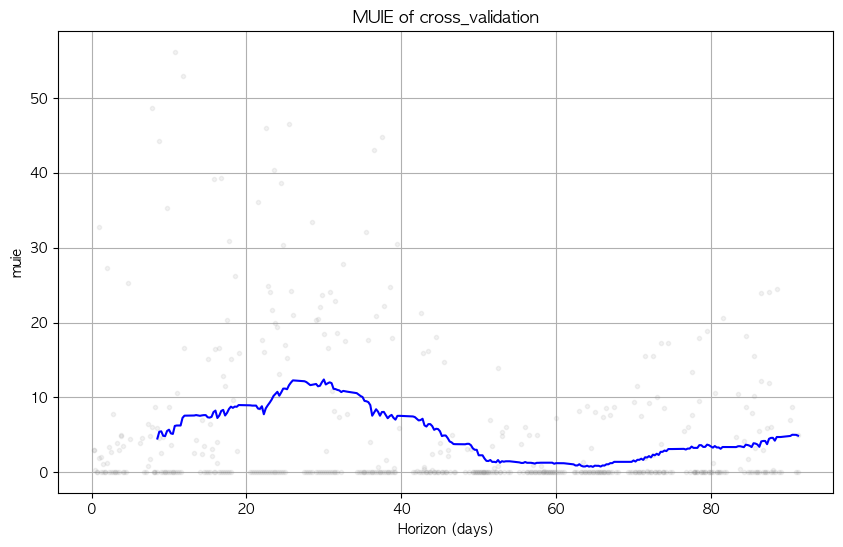

In [57]:
fig = plot_cross_validation_metric(df_cv, metric='muie')